Na danych dotyczących diagnozy raka piersi dostępnych tutaj:


https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra


oszacuj regresję logistyczną przewidującą czy dana osoba ma raka piersi czy też nie. Podziel zbiór na zbiory uczący i testowy, przyjmując że ten drugi ma stanowić 20% obserwacji. Nie regularyzuj modelu ani nie usuwaj zmiennych. Po oszacowaniu modelu:


a) wyznacz jego czułość i trafność predykcji dla progu odcięcia równego 0.5

b) napisz funkcję optymalizującą próg odcięcia pod warunkiem mierzonych finansowo kosztów terapii. Niech:
- koszt poprawnego zaklasyfikowania chorej osoby i natychmiastowej terapii wyniesie 48,477*
- koszt poprawnego zaklasyfikowania osoby zdrowej wyniesie 0
- koszt niepoprawnego zaklasyfikowania chorej osoby jako zdrowej i znacznie późniejszego wykrycia nowotworu wyniesie 89,463*
- koszt niepoprawnego zaklasyfikowania osoby zdrowej jako chorej i skierowania jej na dalsze testy wyniesie 751*

c) zoptymalizuj próg odcięcia. Dla nowo wyznaczonej jego wartości ponownie wylicz czułość i trafność predykcji. Co zauważasz?


PRacę można przygotować w Julii, Pythonie lub R.


* Źródło: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4822976/

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

SEED = 42

In [2]:
data = pd.read_csv('../data/data_slm/dataR2.csv')

In [3]:
data.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


Data Set Information:

There are 10 predictors, all quantitative, and a binary dependent variable, indicating the presence or absence of breast cancer.
The predictors are anthropometric data and parameters which can be gathered in routine blood analysis.
Prediction models based on these predictors, if accurate, can potentially be used as a biomarker of breast cancer.

Attribute Information:

Quantitative Attributes:
Age (years)
BMI (kg/m2)
Glucose (mg/dL)
Insulin (µU/mL)
HOMA
Leptin (ng/mL)
Adiponectin (µg/mL)
Resistin (ng/mL)
MCP-1(pg/dL)

Labels:
1=Healthy controls
2=Patients

In [4]:
y = data['Classification']
X = data.drop('Classification', axis=1)
y = y.apply(lambda x: 0 if x==1 else 1)

In [11]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=SEED)
clf = LogisticRegression(penalty = 'none', random_state=SEED, max_iter=1000).fit(X_train, y_train)

array([[-2.38308378e-02, -1.20355912e-01,  9.52194569e-02,
         1.92078453e-01, -5.67372508e-01, -1.53268882e-02,
         2.40011097e-03,  4.27985440e-02,  5.46477063e-04]])

***A***

In [6]:
print('Czułość = %.3f' % recall_score(y_holdout, clf.predict(X_holdout)))
print('Trafność = %.3f' % accuracy_score(y_holdout, clf.predict(X_holdout)))

Czułość = 0.833
Trafność = 0.875


***B***

In [7]:
def threshold_optima(model, table=False, plot=False):

    thresholds = np.linspace(0.1, 0.9, 81)
    results = pd.DataFrame(columns = ["threshold", "tn", "fp", "fn", "tp", "costs"])
    for threshold in thresholds:
        y_new_pred = (model.predict_proba(X_holdout)[:,1] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_holdout, y_new_pred).ravel()
        
        costs = 48477 * tp + 0 * tn + 89463 * fn + 751 * fp
        
        output = pd.Series([threshold, tn, fp, fn, tp, costs], index=results.columns)
        results = results.append(output, ignore_index=True)
    idx = np.argmin(results['costs'])
    print("Najlepszy próg odcięcia = %.2f" % thresholds[idx])
    
    if table != False:
        return results
    
    if plot != False:
        plt.figure(figsize=(10,5)) 
        plt.plot(results['threshold'], results['costs'], marker='.', label='costs', color='green')
        plt.xlabel('threshold')
        plt.ylabel('costs')
        plt.legend()
        plt.show();

Najlepszy próg odcięcia = 0.22


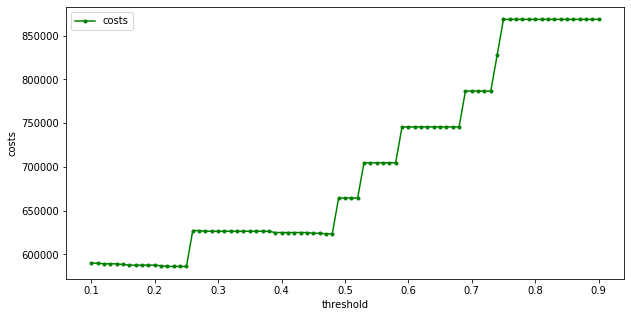

In [8]:
threshold_optima(clf, plot=True)

***C***

In [10]:
y_new_pred = (clf.predict_proba(X_holdout)[:,1] >= 0.22).astype(int)
print('Czułość = %.3f' % recall_score(y_holdout, y_new_pred))
print('Trafność = %.3f' % accuracy_score(y_holdout, y_new_pred))

Czułość = 1.000
Trafność = 0.750


Jeżeli chodzi o diagnozie raka piersi, to najważniejsze jest zmnejszyć ilość FN i powiększyć ilość TN.Czułość (True Positive rate) mierzy odsetek pozytywów, które są prawidłowo zidentyfikowane. W tym wupadku сzułość jest najlepszą miarą i równa się 1.